In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
from helper import *
from load_dataframes import load_all
from plates import plates,timestep
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
import seaborn as sns
import matplotlib.pyplot as plt
logging.getLogger().setLevel(logging.WARNING)




c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_figure = r"C:\Users\coren\Documents\PhD\paper\PandC\Fig1"


2024-03-31 15:52:29,243-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


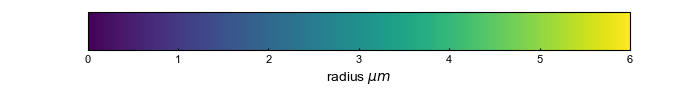

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(7, 1))
fig.subplots_adjust(bottom=0.5)

# Create a colormap
cmap = mpl.cm.viridis

# Create a norm instance to map values to colors
norm = mpl.colors.Normalize(vmin=0, vmax=6)

# Create a colorbar
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                               norm=norm,
                               orientation='horizontal')
ax.set_xlabel("radius $ \mu m$")
# plt.show()
plt.savefig(os.path.join(path_figure,'Figure1F.pdf'), transparent=True, bbox_inches='tight')


In [4]:
df,final_data = load_all(plates)

C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:111: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['start'] = pd.to_datetime(df_sum['start'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:112: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['crossed']  = pd.to_datetime(df_sum['crossed'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:113: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsi

In [5]:
def calculate_derivative(df, column, new_column, window=1):
    # Ensure the DataFrame is sorted by 'unique_id' and 'time_since_begin_h'
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    
    # Calculate the time difference and value difference over the desired window
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_h'].transform(lambda x: x.diff(window)).fillna(0)
    df['value_diff'] = df.groupby('unique_id')[column].transform(lambda x: x.diff(window)).fillna(0)

    # Calculate the derivative (value difference divided by time difference)
    # Be cautious about dividing by zero. If 'time_diff' is 0, set derivative to NaN or handle accordingly.
    df[new_column] = df.apply(lambda x: x['value_diff'] / x['time_diff'] if x['time_diff'] != 0 else None, axis=1)

    # Drop the helper columns
    df.drop(['time_diff', 'value_diff'], axis=1, inplace=True)
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    df['time_since_begin_hour'] = df['time_since_begin_h']
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)
calculate_integral(final_data,f'tot_surface_area_study',f'integrated_SA')
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_biovolume', window=5)
calculate_derivative(final_data,f'tot_volume',f'derivative_tot_biovolume', window=5)

Vmax = 3e-9*25 #ugP/um2/hour
density = 1e-6 #ug/um3
dry_wet_ratio = 0.3
carbon_ratio = 0.5
carbon_ratio_spore = 0.9
dry_wet_ratio_spore = 0.9
density_spore = 0.9e-6
respiration_ratio = 0.5
final_data['P_rate'] =final_data['tot_surface_area_study']*Vmax
final_data['C_rate'] = final_data['derivative_biovolume']*density*dry_wet_ratio*carbon_ratio/respiration_ratio
final_data['totC_hypha'] = final_data['tot_biovolume_study']*density*dry_wet_ratio*carbon_ratio
final_data['tot_volume'] = final_data['spore_volume']+final_data['tot_biovolume_study']
final_data['totC_spore'] = final_data['spore_volume']*density_spore*dry_wet_ratio_spore*carbon_ratio_spore
final_data['totC_tot'] = final_data['totC_hypha'] + final_data['totC_spore']

final_data = final_data.reset_index(drop=True)

In [6]:
df['FungalSide'] = df['FungalSide'].fillna("100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")
df['FungalSide'] = df['FungalSide'].replace("100P100N100C","100P/100N/100C")

df['treatment'] = df['treatment'].replace("1P100N100C","1P/100N/100C")
df['fungus'] = df['fungus'].replace("A5sp3","A5")


In [7]:
df['category_combination'] = df[['treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)
df['size_point'] = 20
marker_symbols = {
    "C2": 'circle',
    "A5": 'square',
    "Agg": 'diamond',
    "Clarum": 'cross',
    "C3": 'star',
    
    
    # Add more mappings as needed
}
df['full_category_combination'] = df[['fungus','treatment', 'FungalSide',"real_root"]].apply(lambda x: '_'.join(x.astype(str)), axis=1)

# Map the strain to the marker symbol in the DataFrame
df['marker'] = df['fungus'].map(marker_symbols)


ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (5).

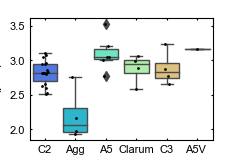

In [8]:
n_colors = len(df['fungus'].unique())

palette = sns.color_palette("rainbow", n_colors)
strain_to_color = dict(zip(df['fungus'].unique(), palette))
cm = 1/2.54  # centimeters in inches

fig,ax = plt.subplots(figsize = (6*cm,4*cm))
select= df[df['real_root']=="Carrot Toby"]
select= select[select['FungalSide']=="100P/100N/100C"]
select= select[select['treatment']=="1P/100N/100C"]
sns.boxplot(select,y="radius",x = "fungus",palette=palette)
sns.stripplot(select,y="radius",x = "fungus",color= "black",size=2)
ax.set_ylabel('radius \n ($\mu m$)')
ax.set_xlabel('strain')
ax.set_xticklabels(['']*5)
plt.savefig(os.path.join(path_figure,'Figure1D.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
df['plate_id'].unique()

In [9]:

plates2 = [
          "527_20230106",

]
all_analysis_folders = get_analysis_folders()
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates2)]
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders)


In [10]:
time_hypha_info['unique_hypha']=time_hypha_info["end"].astype(int).astype(str)+"_"+time_hypha_info["unique_id"].astype(str)
time_hypha_info['radius']=time_hypha_info["av_width"]/2
min_num_occ = 30
max_speeds = time_hypha_info.groupby("unique_hypha").max()["speed"]
correct_tracks = max_speeds.loc[max_speeds <= 450]
select = time_hypha_info.loc[time_hypha_info["unique_hypha"].isin(correct_tracks.index)]
select = select.loc[select["distance_final_pos"] >= 400]
select = select.loc[select["speed"].between(80, 400)]
select = select.loc[select["in_ROI"] == "True"]
num_occ = select.groupby("unique_hypha").count()["speed"]
correct_tracks = num_occ.loc[num_occ >= min_num_occ]
select = select.loc[select["unique_hypha"].isin(correct_tracks.index)]
len(select["unique_hypha"].unique())

13

In [11]:
select.columns

Index(['time_since_begin_h', 'folder', 'Plate', 'unique_id', 'datetime',
       'PrincePos', 'root', 'strain', 'medium', 'av_width', 'degree',
       'distance_final_pos', 'end', 'has_reached_final_pos', 'in_ROI', 'pos_x',
       'pos_y', 'speed', 'time_init', 'time_since_begin_exp',
       'time_since_emergence', 'timedelta', 'timestep', 'timestep_init',
       'width_root_edge', 'width_tip_edge', 'unique_hypha', 'radius'],
      dtype='object')

<AxesSubplot: xlabel='time_since_emergence', ylabel='radius'>

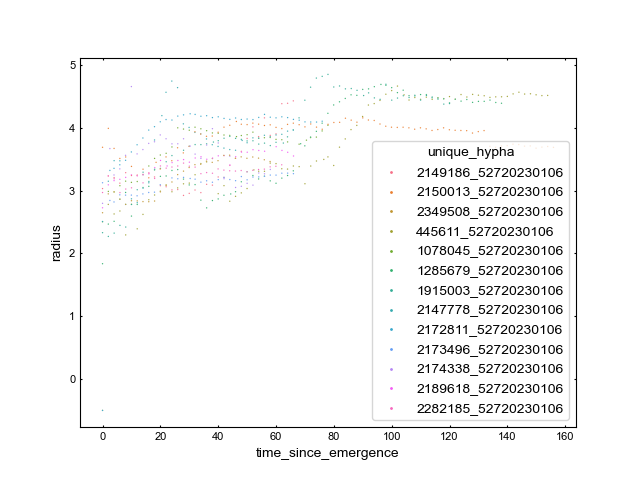

In [12]:
fig, ax = plt.subplots()
sns.scatterplot(select,x='time_since_emergence',y='radius',hue = "unique_hypha")

In [36]:
len(select_width['unique_hypha'].unique())

13

C:\Users\coren\AppData\Local\Temp\ipykernel_18996\3139497234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_width['time_bin'] = pd.cut(select_width['time_since_emergence'], bins=num_bins)
C:\Users\coren\AppData\Local\Temp\ipykernel_18996\3139497234.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_width['time_bin_mid'] = select_width['time_bin'].apply(lambda x: x.mid)


2024-03-31 16:09:14,177-[WARNING]- fontTools.subset:2983 -> meta NOT subset; don't know how to subset; dropped


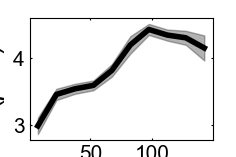

In [35]:
fig,ax = plt.subplots(figsize = (6*cm,4*cm))
# Filter the dataframe for rows where 'av_width' is greater than 0
select_width = select[select['av_width'] > 0]
select_width = select[select['time_since_emergence'] <= 150]
num_bins = 10

select_width['time_bin'] = pd.cut(select_width['time_since_emergence'], bins=num_bins)
select_width['time_bin_mid'] = select_width['time_bin'].apply(lambda x: x.mid)

# sns.lineplot(select_width,x='time_bin_mid',y='radius',hue = "unique_hypha",estimator ="median",ci=None)


# Number of bins; adjust as needed

# Bin the 'time_since_emergence' data into evenly separated intervals

# Compute the mean 'av_width' for each bin
bin_avg = select_width.groupby('time_bin')['radius'].mean()

# Compute the standard error for 'av_width' for each bin
bin_sem = select_width.groupby('time_bin')['radius'].sem()

# Compute the 95% confidence intervals
conf_intervals = 1.96 * bin_sem
lower_bound = bin_avg - conf_intervals
upper_bound = bin_avg + conf_intervals

# Plot the binned average 'av_width' against the middle of each 'time_since_emergence' bin with the confidence interval
bin_centers = [interval.mid for interval in bin_avg.index]
ax.plot(bin_centers, bin_avg.values, label='Overall Average', color='black',linewidth = 4)
ax.fill_between(bin_centers, lower_bound, upper_bound, color='black', alpha=0.3, label='95% CI')

ax.set_xlabel('$\Delta t_b$ (hours)',fontsize = 20)
ax.set_ylabel('radius \n ($\mu m$)',fontsize = 20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.legend().remove()
plt.savefig(os.path.join(path_figure,'Figure1E.pdf'), transparent=True, bbox_inches='tight')
